In [1]:
import json
import glob
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, LogisticRegressionCV, RidgeClassifierCV
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')
r_state = 2543

In [2]:
####################################
## Setup
####################################

## Read csv file (skills)
df_skills = pd.read_csv('all_skills.csv')

## Read JSON file (dataset)
def get_df_from_json(jsfile):
    with open(jsfile, 'r') as file:
        js_jobs = json.load(file)
    df_jobs = pd.json_normalize(js_jobs)
    return df_jobs

df1 = get_df_from_json('ba_pages.json')
df2 = get_df_from_json('ds_pages.json')
df3 = get_df_from_json('da_pages.json')

df_jobs = pd.concat([df1, df2, df3]).reset_index(drop = True)
df_jobs

,Job Role,Role Code,Company,Location,Job Description,Additional Details.Salary Estimate,Additional Details.Education,Additional Details.Skills,Additional Details.Years of Experience
0,Sales & Marketing Analyst (Bilingual in Korean),3,Pulmuone Foods USA Inc.,"Buena Park, CA",Company Overview Pulmuone&rsquos mission i...,$65K - $75K,[Bachelor's degree],"[Bilingual, Sales, Nielsen, Korean, Communicat...",[3]
1,Business System Analyst,3,"Latitude 36 Foods, LLC","Salinas, CA",Shift: 1st Shift \n \nCompensation Deta...,$87K - $99K,[Bachelor's degree],"[Microsoft Excel, Writing skills, ERP systems,...",[]
2,Business Analyst,3,Vastek Inc,"California City, CA","Hello, We are looking for Business Analyst. ...",$30.00 Per Hour,[Bachelor's degree],"[Writing skills, SQL, Communication skills]",[]
3,Business Systems Analyst,3,Fashion Nova - Careers,"Vernon, CA",ABOUT US \n \nFashion Nova is an inclusiv...,$74K - $113K,[Bachelor's degree],"[Jira, ERP systems, Warehouse management syste...",[]
4,"Logistics Analyst, Operations (Bilingual Chine...",3,"YunExpress USA, Inc.","Los Angeles, CA",YunExpress USA is a rapidly growing logistics...,$50K - $60K,[],"[Bilingual, Mandarin, Microsoft Excel, Logisti...",[1]
...,...,...,...,...,...,...,...,...,...
2695,Data Science Analyst,2,REVOLVE,"Cerritos, CA",Meet REVOLVE: \nREVOLVE is the next-ge...,$90K,[Master's degree],"[Computer science, E-commerce, SQL, Analysis s...",[1]
2696,Data Analyst,2,TechTrueUP,"Thousand Oaks, CA",ONSITE - AMA Engineering background over comp...,$50.00 - $55.00 Per Hour,"[Master's degree, Bachelor's degree]","[Mechanical engineering, MATLAB, R, Data analy...",[2]
2697,Data Analyst,2,Exclusive Wireless T- Mobile,"Fresno, CA",Position: Bonus Data Analyst Location: ...,$45K - $56K,[],"[Power BI, Microsoft Excel, SQL, Analysis skil...",[2]
2698,Reporting and Data Analyst,2,Monster Energy,"Corona, CA",The Reporting &amp Data Analyst gathers...,$24.00 - $32.96 Per Hour,[],"[Microsoft Powerpoint, Microsoft Word, Microso...",[]


In [3]:
########################################################################
## Data processing - adding all the skills as columns to the df
########################################################################

## Convert all string values to lowercase
df_skills = df_skills.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df_jobs = df_jobs.applymap(lambda x: x.lower() if isinstance(x, str) else x)

## In Linkedin, there is no additional details. selected only some columns for compatibility
df_jobs = df_jobs.loc[:, ['Job Role', 'Role Code', 'Company', 'Location', 'Job Description']]

## Make new columns that will be 1 or 0 based on if that skill is present in the job description
skills_list = df_skills['skills'].tolist()
for skill in skills_list:
    df_jobs[skill] = [1 if skill in job_desc else 0 for job_desc in df_jobs['Job Description']]

## Define X (features) and Y (target) then split into training set and test set
X = df_jobs.iloc[:, 5:]
Y = df_jobs['Role Code']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=r_state)

X_train

,communication skills,sql,python,analysis skills,microsoft excel,r,tableau,analytics,machine learning,data analysis skills,...,growing experience,network administration,stata,s3,home care,qualitative research interviewing,hubspot,hyperion,social media marketing,zendesk
161,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1904,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1310,0,1,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1112,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1617,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1893,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
481,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2121,1,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1781,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


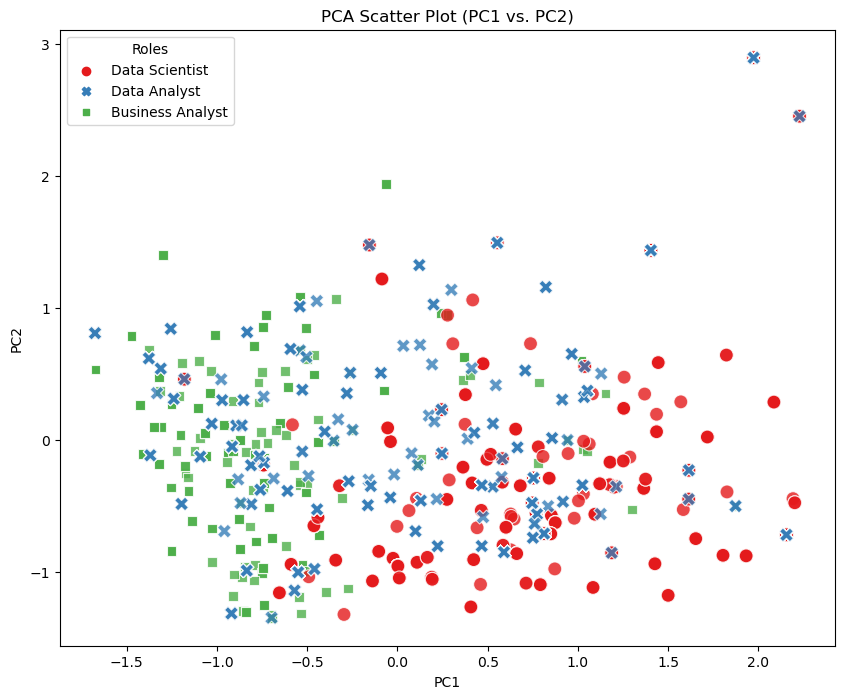

In [4]:
#############################################
## Basic scatter plots to do some EDA
#############################################

## Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

## Create a DataFrame with PCA results and role codes
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Role Code'] = Y

## Scatter plot
plt.figure(figsize=(10, 8))
scatter=sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Role Code', style='Role Code', palette='Set1', s=100, alpha=0.8)
role_labels = {1: 'Data Scientist', 2: 'Data Analyst', 3: 'Business Analyst'}
legend_handles = scatter.get_legend_handles_labels()[0]
plt.legend(legend_handles, [role_labels[int(l.get_text())] for l in scatter.get_legend().texts], title='Roles', loc='best')
plt.title('PCA Scatter Plot (PC1 vs. PC2)')
plt.show()

In [5]:
# Add a constant to the independent variables (it's a requirement for statsmodels)
X_train_const = sm.add_constant(X_train)

# Fit the multi-class logistic regression model
model = sm.MNLogit(Y_train, X_train_const)
result = model.fit() 

# Get the p-values
result.pvalues

Optimization terminated successfully.
         Current function value: nan
         Iterations 10


,0,1
communication skills,NaN,NaN
sql,NaN,NaN
python,NaN,NaN
analysis skills,NaN,NaN
microsoft excel,NaN,NaN
...,...,...
qualitative research interviewing,NaN,NaN
hubspot,NaN,NaN
hyperion,NaN,NaN
social media marketing,NaN,NaN


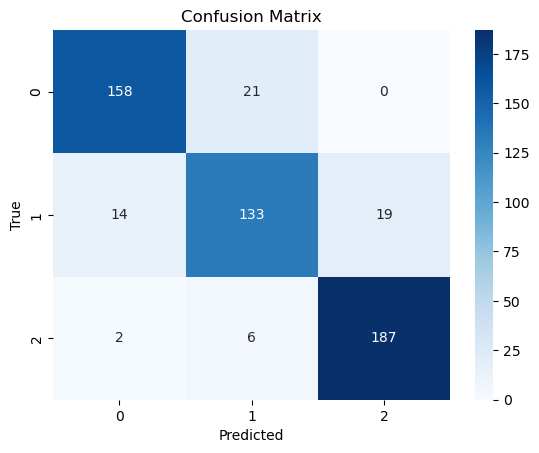

Logistic Regression accuracy: 0.8851851851851852


In [6]:
###########################
## Logistic regression
###########################

## Predict
logreg = LogisticRegression(solver='liblinear', multi_class='ovr')
logreg.fit(X_train, Y_train)
logreg_preds = logreg.predict(X_test)
logreg_accuracy = accuracy_score(Y_test, logreg_preds)

# Plot Confusion matrix 
cm = confusion_matrix(Y_test, logreg_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print("Logistic Regression accuracy:", logreg_accuracy)

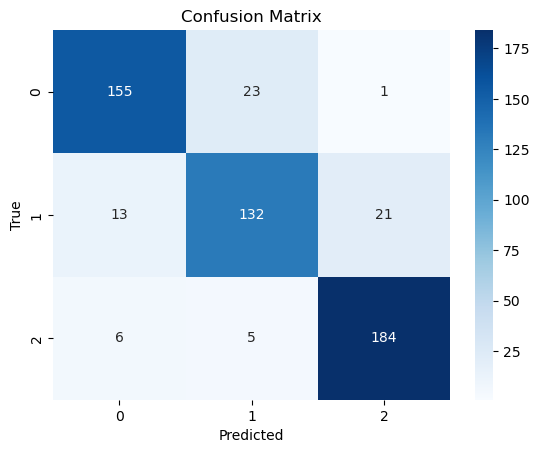

Ridge Classifier with CV accuracy: 0.8722222222222222


In [7]:
######################################################
## Ridge classifier with cross-validation
######################################################

ridge_cv = RidgeClassifierCV(alphas=[0.1, 1.0, 10.0], cv=5)
ridge_cv.fit(X_train, Y_train)
ridge_cv_preds = ridge_cv.predict(X_test)
ridge_cv_accuracy = accuracy_score(Y_test, ridge_cv_preds)

cm = confusion_matrix(Y_test, ridge_cv_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print("Ridge Classifier with CV accuracy:", ridge_cv_accuracy)

In [8]:
#################
## Lasso
#################
#### Keep in mind that using Lasso regression for a classification problem might not be the best approach, 
#### as the model is not designed for this purpose.
#### plot is meaningless. lasso_preds have same value

## Get p-value
#### Calculating p-values for coefficients in the Lasso model is not straightforward
#### Because Lasso involves L1 regularization, which doesn't have closed-form solutions 
#### for standard errors like in ordinary least squares.

lasso = Lasso()
lasso.fit(X_train, Y_train)
lasso_preds = np.round(lasso.predict(X_test))
lasso_accuracy = accuracy_score(Y_test, lasso_preds)
print("Lasso accuracy:", lasso_accuracy)

Lasso accuracy: 0.3074074074074074


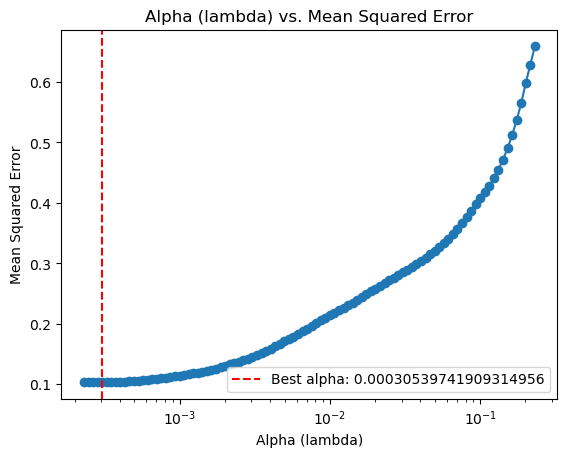

Lasso with CV accuracy: 0.8518518518518519 with The Best Lambda: 0.00030539741909314956


In [9]:
###################################################
## Lasso with cross-validation
###################################################
#### Keep in mind that also using Lasso regression CV for a classification problem might not be the best approach, 
#### as the model is not designed for this purpose.

## Get p-value
#### Calculating p-values for coefficients in the Lasso model is not straightforward
#### Because Lasso involves L1 regularization, which doesn't have closed-form solutions 
#### for standard errors like in ordinary least squares.

lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, Y_train)
lasso_cv_preds = np.round(lasso_cv.predict(X_test))
lasso_cv_accuracy = accuracy_score(Y_test, lasso_cv_preds)

best_alpha = lasso_cv.alpha_
mean_mse = np.mean(lasso_cv.mse_path_, axis=1)
alphas = lasso_cv.alphas_
plt.plot(alphas, mean_mse, marker='o')
plt.axvline(best_alpha, linestyle='--', color='red', label=f'Best alpha: {best_alpha}')
plt.xlabel('Alpha (lambda)')
plt.ylabel('Mean Squared Error')
plt.xscale('log')
plt.title('Alpha (lambda) vs. Mean Squared Error')
plt.legend()
plt.show()
print("Lasso with CV accuracy:", lasso_cv_accuracy, "with The Best Lambda:", best_alpha)

In [10]:
########################################
## Get permutation feature importance
########################################
def feature_importance(model, X_test, Y_test, n, title):    
    
    ## Calculate permutation feature importance
    result = permutation_importance(model, X_test, Y_test, n_repeats=5, random_state=r_state, scoring='neg_mean_squared_error')
    importance_df = pd.DataFrame({"feature": X_test.columns.tolist(), "importance": result.importances_mean})

    ## Select top-n 
    importance_df = importance_df.sort_values(by="importance", ascending=False).head(n)

    ## plot
    plt.figure()
    plt.bar(importance_df["feature"], importance_df["importance"])
    plt.xlabel("Feature Name")
    plt.ylabel("Permutation Importance")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

    return(importance_df)

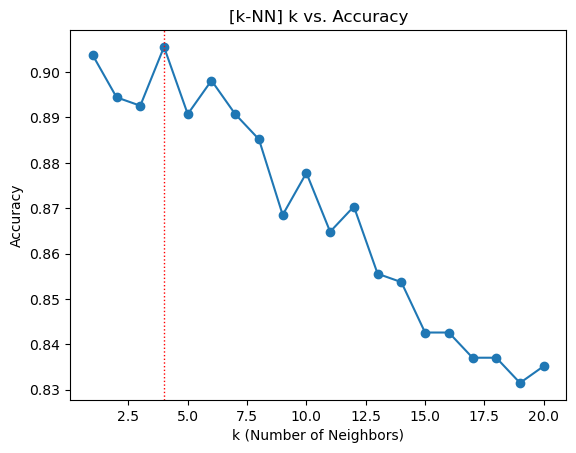

k-NN classifier accuracy: 0.9055555555555556 when k = 4


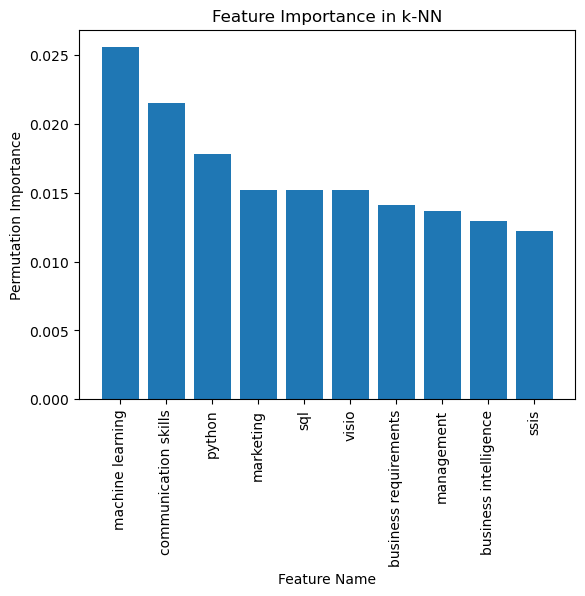

In [11]:
########################
## k-NN
########################

## Create and fit the k-NN classifier. Find best k and calculate accuracy
k_values = list(range(1, 21))
accuracy_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    knn_preds = knn.predict(X_test)
    knn_accuracy = accuracy_score(Y_test, knn_preds)
    accuracy_scores.append(knn_accuracy)    

## Plot
knn_max_acc = max(accuracy_scores)
knn_max_k = k_values[accuracy_scores.index(knn_max_acc)]
plt.plot(k_values, accuracy_scores, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('[k-NN] k vs. Accuracy')
plt.axvline(x=knn_max_k, color='r', linewidth=1, linestyle = ':')
plt.show()
print("k-NN classifier accuracy:", knn_max_acc, "when k =", knn_max_k)


## P-value
#### The k-Nearest Neighbors (kNN) algorithm is a non-parametric method, 
#### meaning it does not learn coefficients like linear models. 
#### As a result, there is no direct concept of p-values for kNN. 
#### P-values are used to assess the significance of coefficients in parametric models, 
#### such as linear regression or logistic regression.

## Feature importance
#### Instead of get p-values, we can assess feature importance
#### using permutation feature importance (https://machinelearningmastery.com/calculate-feature-importance-with-python/)
knn = KNeighborsClassifier(n_neighbors = knn_max_k)
knn.fit(X_train, Y_train)
knn_feature = feature_importance(knn, X_test, Y_test, 10, 'Feature Importance in k-NN')


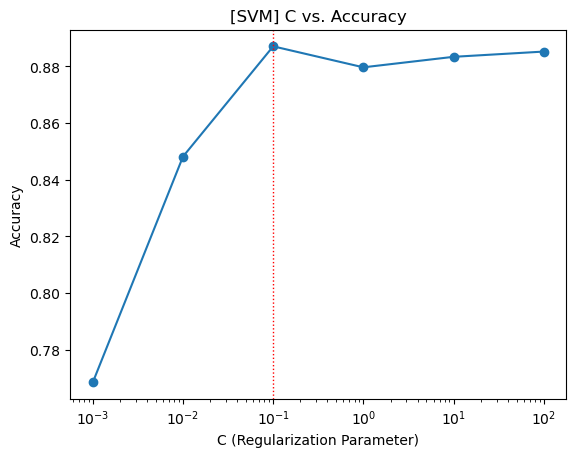

SVM classifier accuracy: 0.8870370370370371 when C = 0.1


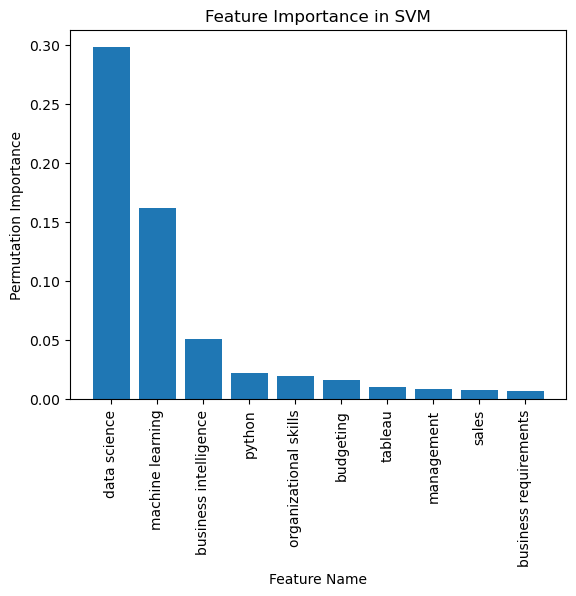

In [12]:
########################
## SVM
########################

## SVM for classification. Find optimal C parameter (regularization parameter) 
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
accuracy_scores = []
for C in C_values:
    svm = SVC(kernel='linear', C = C)
    svm.fit(X_train, Y_train)
    svm_preds = svm.predict(X_test)
    svm_accuracy = accuracy_score(Y_test, svm_preds)
    accuracy_scores.append(svm_accuracy)

## Plot
svm_max_acc = max(accuracy_scores)
svm_max_c = C_values[accuracy_scores.index(svm_max_acc)]
plt.plot(C_values, accuracy_scores, marker='o')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.title('[SVM] C vs. Accuracy')
plt.axvline(x=svm_max_c, color='r', linewidth=1, linestyle = ':')
plt.show()
print("SVM classifier accuracy:", svm_max_acc, "when C =", svm_max_c)

## Feature importance
#### SVM do not have coefficients like linear models, 
#### so there are no direct p-values associated with the features. 
#### Instead of get p-values, we can assess feature importance
svm = SVC(kernel='linear', C = svm_max_c)
svm.fit(X_train, Y_train)
svm_feature = feature_importance(svm, X_test, Y_test, 10, 'Feature Importance in SVM')

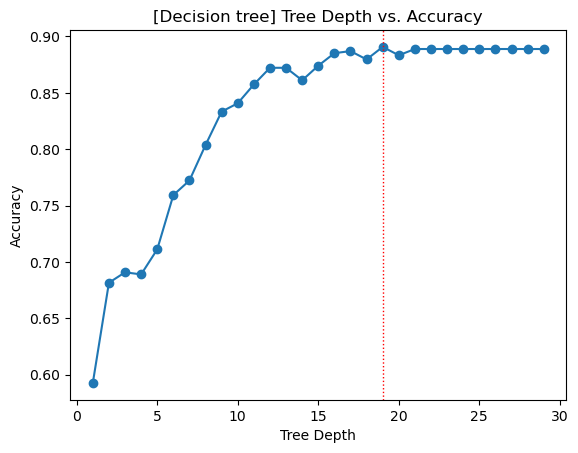

Decision tree classifier accuracy: 0.8907407407407407 when Depth = 19


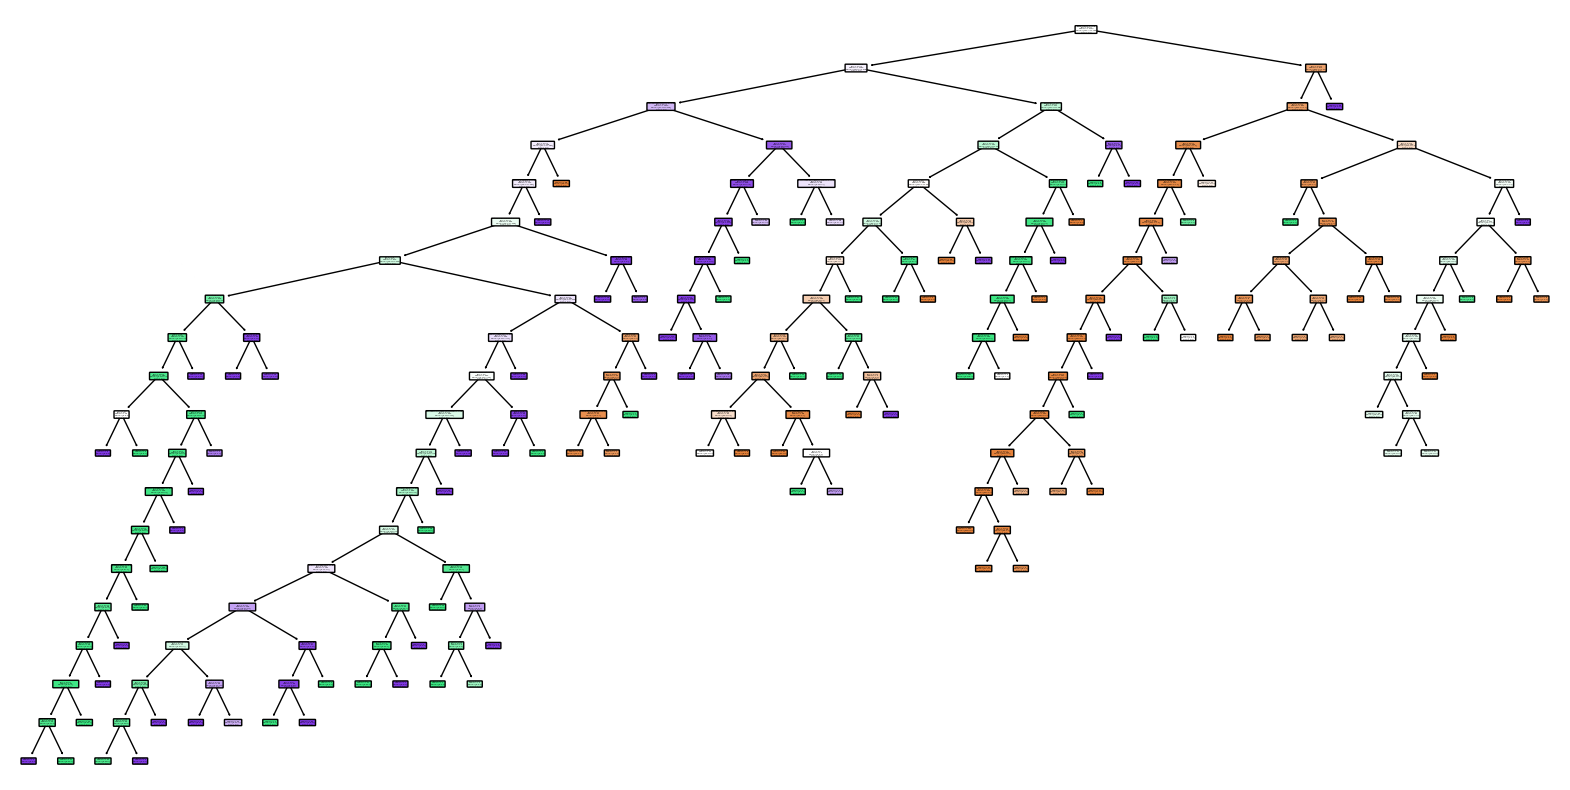

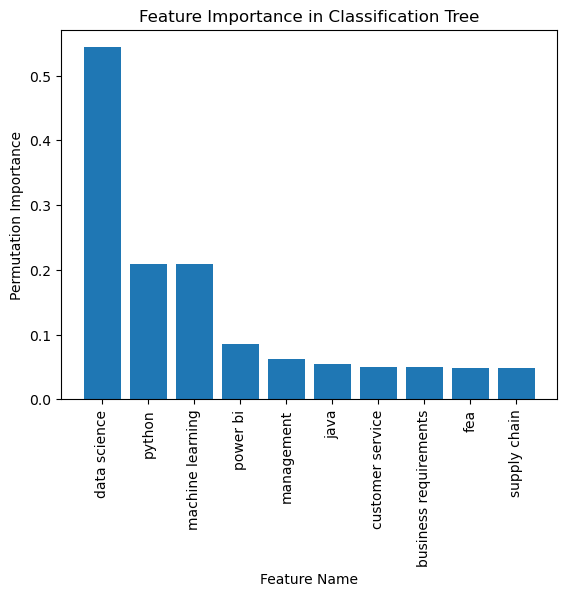

In [13]:
########################
## Decision tree
########################

## Find best depth
max_depths = list(range(1, 30))
accuracy_scores = []
for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=r_state)
    dt.fit(X_train, Y_train)
    dt_preds = dt.predict(X_test)
    dt_accuracy = accuracy_score(Y_test, dt_preds)
    accuracy_scores.append(dt_accuracy)

## Plot
dt_max_acc = max(accuracy_scores)
dt_max_depth = max_depths[accuracy_scores.index(dt_max_acc)]
plt.plot(max_depths, accuracy_scores, marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('[Decision tree] Tree Depth vs. Accuracy')
plt.axvline(x=dt_max_depth, color='r', linewidth=1, linestyle = ':')
plt.show()
print("Decision tree classifier accuracy:", dt_max_acc, "when Depth =", dt_max_depth)

## Plot tree structure
#### important?? i have no idea..
dt = DecisionTreeClassifier(max_depth=dt_max_depth, random_state=r_state)
dt.fit(X_train, Y_train)
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=X_train.columns, class_names=True, rounded=True)
plt.show()

## Feature importance
dt = DecisionTreeClassifier(max_depth=dt_max_depth, random_state=r_state)
dt.fit(X_train, Y_train)
dt_feature = feature_importance(dt, X_test, Y_test, 10,'Feature Importance in Classification Tree')

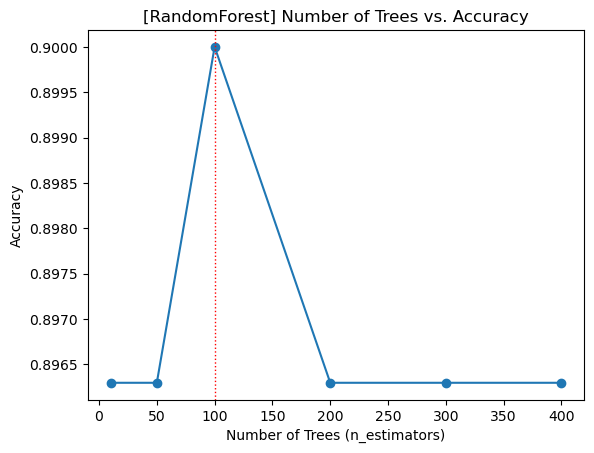

Random forest classifier accuracy: 0.9 when N Estimators = 100


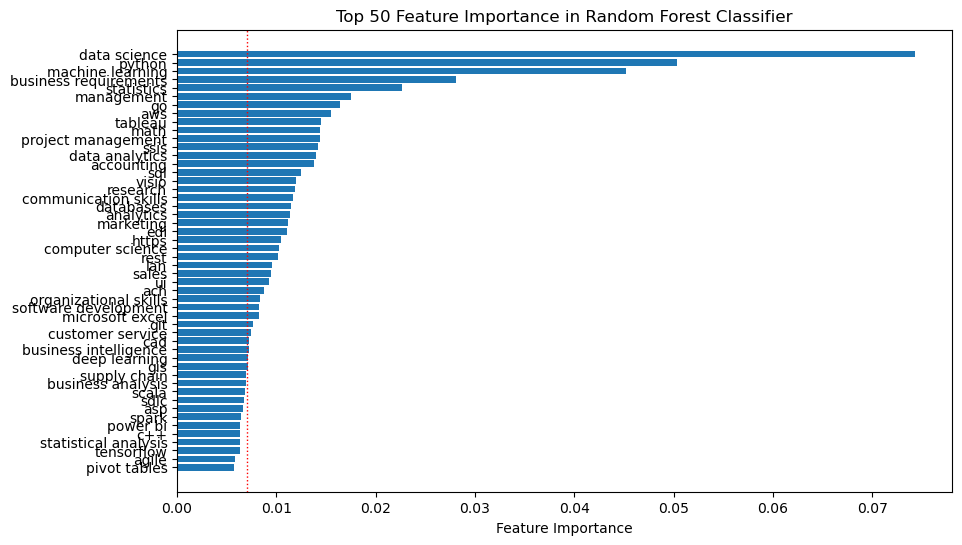

Random forest classifier accuracy with important features: 0.8925925925925926 with threshold = 0.007


In [14]:
######################
## Random forest
######################

## Find n_estimators
n_estimators_values = [10, 50, 100, 200, 300, 400]
accuracy_scores = []
for n in n_estimators_values:
    rf = RandomForestClassifier(n_estimators=n, random_state=r_state)
    rf.fit(X_train, Y_train)
    rf_preds = rf.predict(X_test)
    rf_accuracy = accuracy_score(Y_test, rf_preds)
    accuracy_scores.append(rf_accuracy)

rf_max_acc = max(accuracy_scores)
rf_max_n = n_estimators_values[accuracy_scores.index(rf_max_acc)]
plt.plot(n_estimators_values, accuracy_scores, marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('[RandomForest] Number of Trees vs. Accuracy')
plt.axvline(x=rf_max_n, color='r', linewidth=1, linestyle = ':')
plt.show()
print("Random forest classifier accuracy:", rf_max_acc, "when N Estimators =", rf_max_n)

## Feature importance plot.
n_top_features = 50 # just fot beauti-plot
importance_threshold = 0.007 # in the plot this value seems reasonable
importances = rf.feature_importances_
indices = np.argsort(importances)[-n_top_features:]  
plt.figure(figsize=(10, 6))
plt.barh(range(n_top_features), importances[indices], align='center') 
plt.yticks(range(n_top_features), X_train.columns[indices])
plt.xlabel('Feature Importance')
plt.title(f'Top {n_top_features} Feature Importance in Random Forest Classifier')
plt.axvline(x=importance_threshold, color='r', linewidth=1, linestyle = ':')
plt.show()

## Update dataset using feature importance
#### This is NOT the best accuracy but improves its performance
indices = np.argsort(importances)
important_feature_indices = [index for index in indices if importances[index] > importance_threshold]
X_train_important = X_train.iloc[:, important_feature_indices]
X_test_important = X_test.iloc[:, important_feature_indices]
rf_important = RandomForestClassifier(n_estimators=rf_max_n, random_state=r_state)
rf_important.fit(X_train_important, Y_train)
rf_important_preds = rf_important.predict(X_test_important)
rf_important_accuracy = accuracy_score(Y_test, rf_important_preds)
print("Random forest classifier accuracy with important features:", rf_important_accuracy, "with threshold =", importance_threshold)


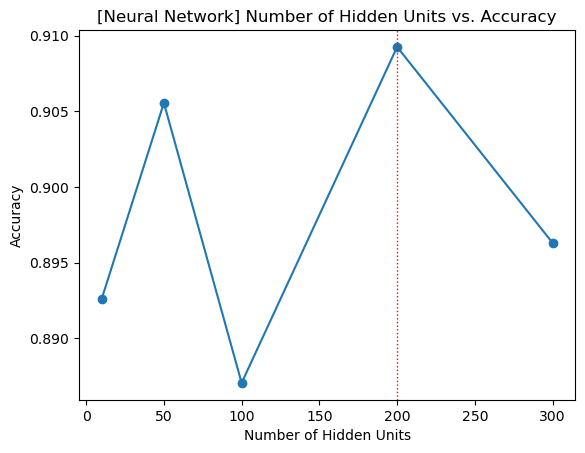

Neural Network classifier accuracy: 0.9092592592592592 when hidden units = 200


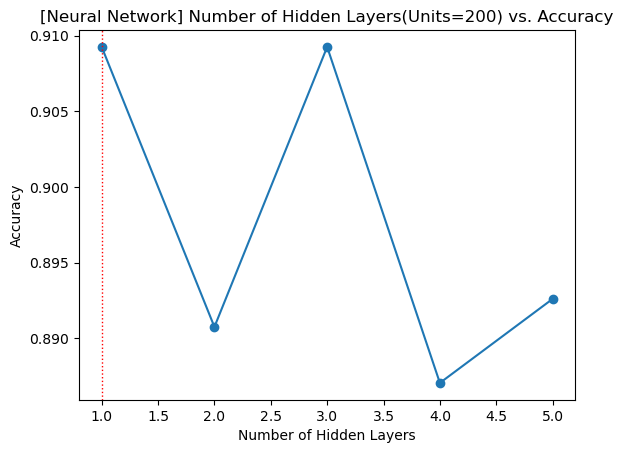

Neural Network classifier accuracy: 0.9092592592592592 when hidden units = 200 and hidden layers = 1


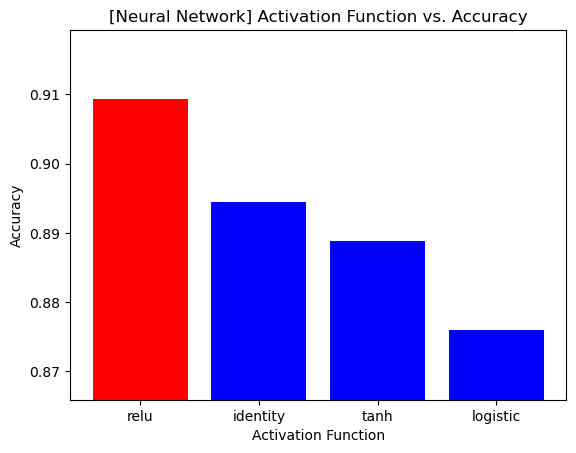

Neural Network classifier accuracy: 0.9092592592592592 when hidden units = 200 and hidden layers = 1 and activation function = relu


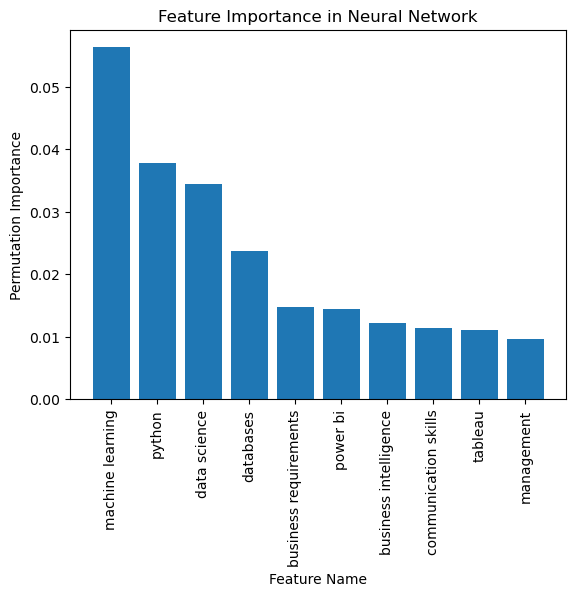

In [15]:
####################
## Neural Network 
####################

## (1) Find accuracy scores for different numbers of hidden units
hidden_units_values = [10, 50, 100, 200, 300]
accuracy_scores = []
for n in hidden_units_values:
    nn = MLPClassifier(hidden_layer_sizes=(n, ), random_state=r_state)
    nn.fit(X_train, Y_train)
    nn_preds = nn.predict(X_test)
    nn_accuracy = accuracy_score(Y_test, nn_preds)
    accuracy_scores.append(nn_accuracy)

nn_max_acc_hu = max(accuracy_scores)
nn_max_hidden_units = hidden_units_values[accuracy_scores.index(nn_max_acc_hu)]
plt.plot(hidden_units_values, accuracy_scores, marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Accuracy')
plt.title('[Neural Network] Number of Hidden Units vs. Accuracy')
plt.axvline(x=nn_max_hidden_units, color='r', linewidth=1, linestyle = ':')
plt.show()
print("Neural Network classifier accuracy:", nn_max_acc_hu, "when hidden units =", nn_max_hidden_units)

## (2) For different numbers of hidden layers
hidden_layers_values = [1, 2, 3, 4, 5]
accuracy_scores = []
for n in hidden_layers_values:
    hidden_layer_sizes = (nn_max_hidden_units,) * n  # Create a tuple with n hidden layers, each with nn_max_hidden_units
    nn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, random_state=r_state)
    nn.fit(X_train, Y_train)
    nn_preds = nn.predict(X_test)
    nn_accuracy = accuracy_score(Y_test, nn_preds)
    accuracy_scores.append(nn_accuracy)

nn_max_acc_hl = max(accuracy_scores)
nn_max_hidden_layers = hidden_layers_values[accuracy_scores.index(nn_max_acc_hl)]
plt.plot(hidden_layers_values, accuracy_scores, marker='o')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.title(f'[Neural Network] Number of Hidden Layers(Units={nn_max_hidden_units}) vs. Accuracy')
plt.axvline(x=nn_max_hidden_layers, color='r', linewidth=1, linestyle = ':')
plt.show()
print("Neural Network classifier accuracy:", nn_max_acc_hu, 
      "when hidden units =", nn_max_hidden_units,  
      "and hidden layers =", nn_max_hidden_layers)

## (3) Find accuracy scores for different activation functions
activation_functions = ['identity', 'logistic', 'tanh', 'relu']
accuracy_scores = []
for activation in activation_functions:
    hidden_layer_sizes = (nn_max_hidden_units,) * nn_max_hidden_layers
    nn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, random_state=r_state)
    nn.fit(X_train, Y_train)
    nn_preds = nn.predict(X_test)
    nn_accuracy = accuracy_score(Y_test, nn_preds)
    accuracy_scores.append(nn_accuracy)

## Sort accuracy scores and activation functions in descending order
sorted_indices = np.argsort(accuracy_scores)[::-1]
sorted_activation_functions = [activation_functions[i] for i in sorted_indices]
sorted_accuracy_scores = [accuracy_scores[i] for i in sorted_indices]

## Set the bar colors, with the top-1 bar in red and the rest in blue
bar_colors = ['red'] + ['blue'] * (len(sorted_activation_functions) - 1)
y_min = min(sorted_accuracy_scores) - 0.01  
y_max = max(sorted_accuracy_scores) + 0.01  

## Plot the ordered bars with custom colors
nn_max_acc_af = max(accuracy_scores)
nn_max_activation_functions = activation_functions[accuracy_scores.index(nn_max_acc_af)]
plt.bar(sorted_activation_functions, sorted_accuracy_scores, color=bar_colors)
plt.ylim(y_min, y_max)
plt.xlabel('Activation Function')
plt.ylabel('Accuracy')
plt.title('[Neural Network] Activation Function vs. Accuracy')
plt.show()
print("Neural Network classifier accuracy:", nn_max_acc_hu, 
      "when hidden units =", nn_max_hidden_units,  
      "and hidden layers =", nn_max_hidden_layers,
      "and activation function =", nn_max_activation_functions)

## Feature importance
nn = MLPClassifier(hidden_layer_sizes=(nn_max_hidden_units,)*nn_max_hidden_layers, activation=nn_max_activation_functions, random_state=r_state)
nn.fit(X_train, Y_train)
nn_feature = feature_importance(nn, X_test, Y_test, 10,'Feature Importance in Neural Network')

In [16]:
################################
## Summary
################################

## Accuract
print("Logistic Regression accuracy:", logreg_accuracy)
print("Ridge Classifier with CV accuracy:", ridge_cv_accuracy)
print("Lasso accuracy:", lasso_accuracy)
print("Lasso with CV accuracy:", lasso_cv_accuracy, 
      "with The Best Lambda:", best_alpha)
print("k-NN classifier accuracy:", knn_max_acc, 
      "when k =", knn_max_k)
print("SVM classifier accuracy:", svm_max_acc, 
      "when C =", svm_max_c)
print("Decision tree classifier accuracy:", dt_max_acc, 
      "when Depth =", dt_max_depth)
print("Random forest classifier accuracy:", rf_max_acc, 
      "when N Estimators =", rf_max_n)
print("Random forest classifier accuracy with important features:", rf_important_accuracy, 
      "with threshold =", importance_threshold)
print("Neural Network classifier accuracy:", nn_max_acc_hu, 
      "when hidden units =", nn_max_hidden_units)
print("Neural Network classifier accuracy:", nn_max_acc_hu, 
      "when hidden units =", nn_max_hidden_units,  
      "and hidden layers =", nn_max_hidden_layers)
print("Neural Network classifier accuracy:", nn_max_acc_hu, 
      "when hidden units =", nn_max_hidden_units,  
      "and hidden layers =", nn_max_hidden_layers,
      "and activation function =", nn_max_activation_functions)

## Feature importance
print("<knn_feature>", knn_feature)
print("<svm_feature>", svm_feature)
print("<dt_feature>", dt_feature)
print("<nn_feature>", nn_feature)

Logistic Regression accuracy: 0.8851851851851852
Ridge Classifier with CV accuracy: 0.8722222222222222
Lasso accuracy: 0.3074074074074074
Lasso with CV accuracy: 0.8518518518518519 with The Best Lambda: 0.00030539741909314956
k-NN classifier accuracy: 0.9055555555555556 when k = 4
SVM classifier accuracy: 0.8870370370370371 when C = 0.1
Decision tree classifier accuracy: 0.8907407407407407 when Depth = 19
Random forest classifier accuracy: 0.9 when N Estimators = 100
Random forest classifier accuracy with important features: 0.8925925925925926 with threshold = 0.007
Neural Network classifier accuracy: 0.9092592592592592 when hidden units = 200
Neural Network classifier accuracy: 0.9092592592592592 when hidden units = 200 and hidden layers = 1
Neural Network classifier accuracy: 0.9092592592592592 when hidden units = 200 and hidden layers = 1 and activation function = relu
<knn_feature>                    feature  importance
8         machine learning    0.025556
0     communication ski